Matriz: (600, 3000) | Etiquetas: {0: 301, 1: 299}

=== Logistic Regression ===
AUROC: 0.966 | AUPR: 0.967
              precision    recall  f1-score   support

           0       0.94      0.77      0.84        60
           1       0.80      0.95      0.87        60

    accuracy                           0.86       120
   macro avg       0.87      0.86      0.86       120
weighted avg       0.87      0.86      0.86       120


=== Random Forest ===
AUROC: 0.987 | AUPR: 0.986
              precision    recall  f1-score   support

           0       0.95      0.90      0.92        60
           1       0.90      0.95      0.93        60

    accuracy                           0.93       120
   macro avg       0.93      0.93      0.92       120
weighted avg       0.93      0.93      0.92       120



<Figure size 640x480 with 0 Axes>

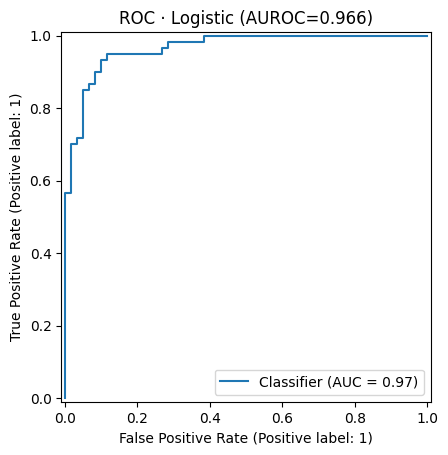

<Figure size 640x480 with 0 Axes>

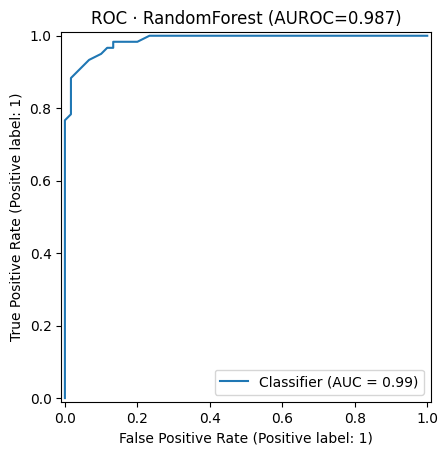

<Figure size 640x480 with 0 Axes>

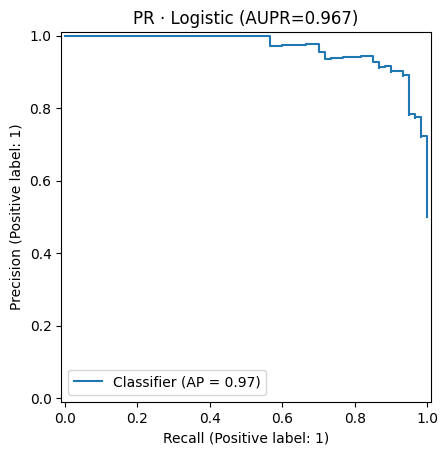

<Figure size 640x480 with 0 Axes>

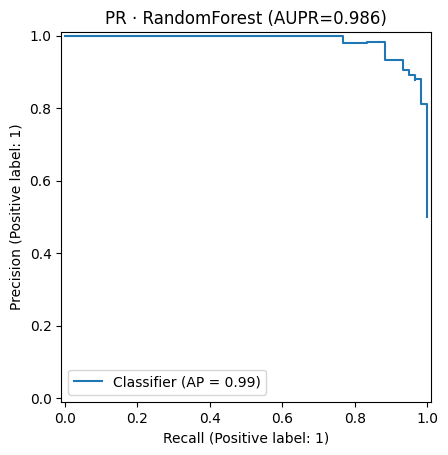

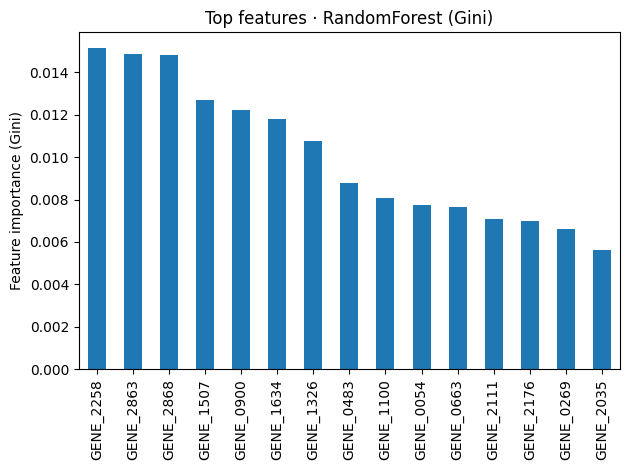


Modelo guardado como omics_sintetico_rf.joblib (descárgalo desde Files)

==== RESUMEN PARA README ====
Logistic Regression — AUROC: 0.966 | AUPR: 0.967
Random Forest      — AUROC: 0.987 | AUPR: 0.986
Figuras: ROC y PR (ambos modelos) + Importancias (Gini).
Nota: dataset sintético que emula expresión génica de alta dimensión; no uso clínico.
Guardadas en /content/figs


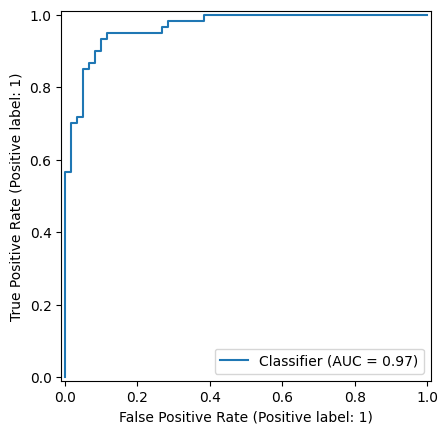

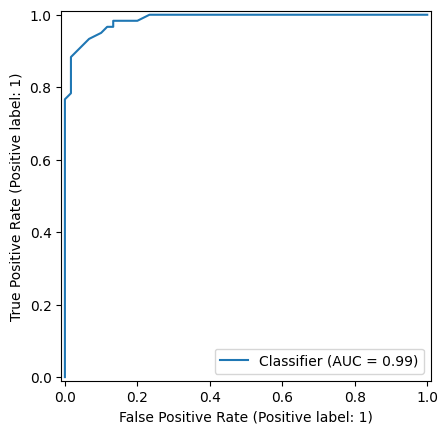

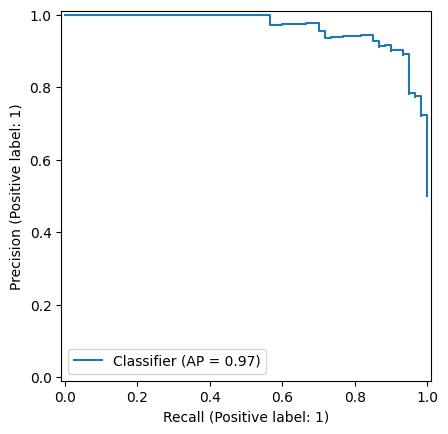

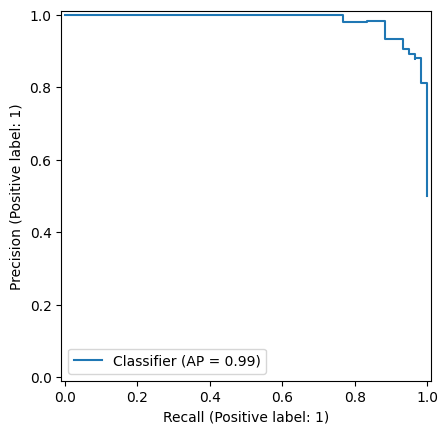

In [1]:
# ==========
# PROYECTO 2 · ÓMICS (SINTÉTICO, FAST) · Tumor vs Normal
# Uso educativo; no clínico. Sin descargas externas. Sin pasos lentos.
# ==========
!pip install -q pandas numpy scikit-learn matplotlib joblib

import numpy as np, pandas as pd, matplotlib.pyplot as plt, warnings, joblib
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, classification_report,
    RocCurveDisplay, PrecisionRecallDisplay
)
warnings.filterwarnings("ignore")

# 1) Datos "ómics-like" más ligeros (RÁPIDO)
#    600 muestras, 3000 "genes", 60 informativos
X, y = make_classification(
    n_samples=600, n_features=3000, n_informative=60, n_redundant=30,
    n_clusters_per_class=2, class_sep=2.0, random_state=42
)
genes = [f"GENE_{i:04d}" for i in range(X.shape[1])]
X = pd.DataFrame(X, columns=genes)
y = pd.Series(y, name="label")   # 1 = “tumor”, 0 = “normal”
print("Matriz:", X.shape, "| Etiquetas:", y.value_counts().to_dict())

# 2) Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3) Modelo 1: Regresión Logística (con escalado)
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", ConvergenceWarning)
pipe_lr = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('clf', LogisticRegression(max_iter=400, solver='liblinear'))
])
pipe_lr.fit(X_train, y_train)
p_lr = pipe_lr.predict_proba(X_test)[:,1]; y_lr = pipe_lr.predict(X_test)
auroc_lr = roc_auc_score(y_test, p_lr); aupr_lr = average_precision_score(y_test, p_lr)
print("\n=== Logistic Regression ===")
print("AUROC:", round(auroc_lr,3), "| AUPR:", round(aupr_lr,3))
print(classification_report(y_test, y_lr))

# 4) Modelo 2: Random Forest (más pequeño → rápido)
rf = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
p_rf = rf.predict_proba(X_test)[:,1]; y_rf = rf.predict(X_test)
auroc_rf = roc_auc_score(y_test, p_rf); aupr_rf = average_precision_score(y_test, p_rf)
print("\n=== Random Forest ===")
print("AUROC:", round(auroc_rf,3), "| AUPR:", round(aupr_rf,3))
print(classification_report(y_test, y_rf))

# 5) Curvas ROC y PR (ambos modelos)
plt.figure(); RocCurveDisplay.from_predictions(y_test, p_lr); plt.title(f'ROC · Logistic (AUROC={auroc_lr:.3f})'); plt.show()
plt.figure(); RocCurveDisplay.from_predictions(y_test, p_rf); plt.title(f'ROC · RandomForest (AUROC={auroc_rf:.3f})'); plt.show()
plt.figure(); PrecisionRecallDisplay.from_predictions(y_test, p_lr); plt.title(f'PR · Logistic (AUPR={aupr_lr:.3f})'); plt.show()
plt.figure(); PrecisionRecallDisplay.from_predictions(y_test, p_rf); plt.title(f'PR · RandomForest (AUPR={aupr_rf:.3f})'); plt.show()

# 6) Importancias de variables (Gini) — rápido y estable
fi = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(15)
plt.figure(); fi.plot(kind="bar"); plt.ylabel("Feature importance (Gini)")
plt.title("Top features · RandomForest (Gini)"); plt.tight_layout(); plt.show()

# 7) Guardar el modelo (RF)
joblib.dump(rf, "omics_sintetico_rf.joblib")
print("\nModelo guardado como omics_sintetico_rf.joblib (descárgalo desde Files)")

# 8) Resumen para README
print("\n==== RESUMEN PARA README ====")
print(f"Logistic Regression — AUROC: {auroc_lr:.3f} | AUPR: {aupr_lr:.3f}")
print(f"Random Forest      — AUROC: {auroc_rf:.3f} | AUPR: {aupr_rf:.3f}")
print("Figuras: ROC y PR (ambos modelos) + Importancias (Gini).")
print("Nota: dataset sintético que emula expresión génica de alta dimensión; no uso clínico.")

# Guardar de nuevo las 4 curvas a PNG
import os
os.makedirs("figs", exist_ok=True)
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

RocCurveDisplay.from_predictions(y_test, p_lr).figure_.savefig("figs/roc_logistic.png", dpi=180, bbox_inches="tight")
RocCurveDisplay.from_predictions(y_test, p_rf).figure_.savefig("figs/roc_rf.png", dpi=180, bbox_inches="tight")
PrecisionRecallDisplay.from_predictions(y_test, p_lr).figure_.savefig("figs/pr_logistic.png", dpi=180, bbox_inches="tight")
PrecisionRecallDisplay.from_predictions(y_test, p_rf).figure_.savefig("figs/pr_rf.png", dpi=180, bbox_inches="tight")
print("Guardadas en /content/figs")

